# Restoring Color to Greyscale Images

In [1]:
import image
import os
import random
import numpy as np
import scipy as sp
import time

import lasagne
import theano
import theano.tensor as T

%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
from matplotlib import cm
figsize(16, 4)

In [11]:
import convnets
import train
reload(convnets)
reload(train)

SIZE = 100
IMDIR = "images/raw"

handles = [os.path.join(IMDIR, h) for h in os.listdir(IMDIR)]
print len(handles)

30113


In [3]:
base = convnets.COLOR_STATS_NET
theano_exprs = convnets.CreateTheanoExprs(
    base_net=base,
    height=SIZE,
    width=SIZE,
    learning_rate=0.001)
net, train_fn, val_fn, prediction, target_var, transformed_target = theano_exprs[:6]
convnets.PrintNetworkShape(net)

DenseLayer (None, 100) => (None, 6)
DenseLayer (None, 5, 23, 23) => (None, 100)
MaxPool2DLayer (None, 5, 46, 46) => (None, 5, 23, 23)
Conv2DLayer (None, 12, 48, 48) => (None, 5, 46, 46)
MaxPool2DLayer (None, 12, 96, 96) => (None, 12, 48, 48)
Conv2DLayer (None, 1, 100, 100) => (None, 12, 96, 96)
DimshuffleLayer (None, 100, 100) => (None, 1, 100, 100)
InputLayer  => (None, 100, 100)


In [12]:
batch_stats, val_stats, err, net  = train.Train(
    num_batches=10,
    validate_every_n_batches=4,
    height=SIZE,
    width=SIZE,
    batch_size=100,
    reps_per_batch=2,
    image_handles=handles,
    val_set_size=500,
    test_set_size=500,
    net=net,
    train_fn=train_fn,
    val_fn=val_fn)

Loading validation and testing images...
Starting training...
Training batch 0 of 2 reps x 100 images. Time = 0.00 seconds. Load time = 1.60 seconds. Error = 1.00000.
Training batch 1 of 2 reps x 100 images. Time = 2.67 seconds. Load time = 2.13 seconds. Error = 0.84145.
Training batch 2 of 2 reps x 100 images. Time = 2.55 seconds. Load time = 1.65 seconds. Error = 0.82193.
Training batch 3 of 2 reps x 100 images. Time = 2.38 seconds. Load time = 1.66 seconds. Error = 0.86830.

Validating...
Validated on 500 images in 1.94 seconds. Error = 0.82698.

Training batch 4 of 2 reps x 100 images. Time = 2.29 seconds. Load time = 1.39 seconds. Error = 0.68932.
Training batch 5 of 2 reps x 100 images. Time = 2.30 seconds. Load time = 1.62 seconds. Error = 0.84653.
Training batch 6 of 2 reps x 100 images. Time = 2.23 seconds. Load time = 1.36 seconds. Error = 0.93851.
Training batch 7 of 2 reps x 100 images. Time = 2.26 seconds. Load time = 1.90 seconds. Error = 0.82424.

Validating...
Validated

In [5]:
images = np.zeros((100, SIZE, SIZE, 3))
train.LoadImages(handles, SIZE, SIZE, 100, images)

104

In [6]:
def ImStat(images):
    for i, color in enumerate(["  red", "green", " blue"]):
        channel = images[:, :, :, i]
        print "{c}: mean={m:.2f}, std={s:.2f}".format(
            c=color, m=channel.mean(), s=channel.std())
    grey = (images[:, :, :, 0] * 0.299 +
            images[:, :, :, 1] * 0.587 +
            images[:, :, :, 2] * 0.114)
    print " grey: mean={m:.2f}, std={s:.2f}".format(
        m=grey.mean(), s=grey.std())
    
    sh = images.shape
    rsh = (sh[0], sh[1] * sh[2], sh[3])
    ch = images.reshape(rsh)
    means = ch.mean(axis=1)
    stds = ch.std(axis=1)
    print "Mean of Means:", means.mean(axis=0)
    print " Std of Means:", means.std(axis=0)
    print " Mean of Stds:", stds.mean(axis=0)
    print "  Std of Stds:", stds.std(axis=0)

In [7]:
ImStat(images)

  red: mean=138.47, std=71.23
green: mean=143.43, std=68.59
 blue: mean=156.06, std=71.30
 grey: mean=143.39, std=66.89
Mean of Means: [ 138.473422  143.434636  156.062334]
 Std of Means: [ 38.00793466  34.52698935  40.49432104]
 Mean of Stds: [ 57.59593963  57.10358429  55.79440904]
  Std of Stds: [ 17.66648806  15.84303042  18.19052111]


In [8]:
evaluator = train.Evaluator(prediction, target_var, transformed_target)

In [9]:
evaluator(images[np.random.randint(0, len(images))])

[array([[-0.05309516,  0.38991007,  0.01509123,  0.03899228,  0.07031941,
          0.10115491]]),
 array([[ 0.10902286, -0.02297689,  0.30560679, -1.0699724 , -1.07071215,
         -0.55244161]])]

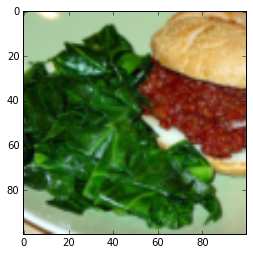

In [13]:
plt.imshow(np.repeat(images, 5, 0)[-123])

In [19]:
evaluator(np.repeat(images, 5, 0)[-123])

[array([[-0.44295723,  0.17634359, -0.5170257 , -0.04266849,  0.02111703,
          0.26203344]]),
 array([[ 0.60395776,  0.02949758,  0.85770819,  1.21892429,  0.63209795,
          0.53957837]])]

In [20]:
# reps_per_batch=6,num_batches=100,batch_size=300,val_set_size=300,test_set_size=300